In [1]:
from plot_params import * 
from scipy.stats import qmc
from tqdm import tqdm
from time import time
from joblib import Parallel, delayed
import numpy as np 
import os
# banaan

In [2]:
""" 
All functions needed in the notebook.
"""

def check_inside_mandlebrot(i, c):
    z = 0 + 0j
    for i in range(i):
        z = np.square(z) + c
        if np.abs(z) > 2:
            return False
    return True


def mandlebrot_area(i, s, sampling_function):
    random_complex_numbers = sampling_function(s)

    in_mandlebrot = 0
 
    for z in random_complex_numbers:
        if check_inside_mandlebrot(i, z):
            in_mandlebrot += 1

    area = in_mandlebrot / s * area_box

    return area


def expected_variance(theta, n):
    return theta * (1 - theta) / n

def permute(x, N):
    for i in reversed(range(1,N-1)):
        h = x[i]
        r = np.random.randint(N)
        x[i] = x[r]
        x[r] = h
    return x

def OLHC_samples(n):
    M = int(np.sqrt(n))
    scale = 4/n
    x = np.empty(shape=(M,M))
    y = np.empty(shape=(M,M))
    m = 0
    samples = np.empty(n,dtype=np.complex_)
    for i in range(M):
        for j in range(M):
            m = m + 1
            x[i,j] = m
            y[i,j] = m
            
    for i in range(M):
        x[:,i] = permute(x[:,i],M)
        y[:,i] = permute(y[:,i],M)
 
    for i in range(M):
        for j in range(M):
            reals = -2 + scale*(x[i,j] + np.random.random(1))
            imags = -2 + scale*(y[i,j] + np.random.random(1))
            samples[M*i+j] = reals + imags*1j
    return samples

def LHC_samples(n):
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=n) 
    sample = qmc.scale(sample, [r_min, i_min], [r_max, i_max])

    reals = sample[:, 0]
    imags = sample[:, 1]

    samples = reals + imags * 1j
    return samples


def uniform_samples(n):
    real = np.random.uniform(r_min, r_max, size=n)
    imaginary = np.random.uniform(i_min, i_max, size=n) * 1j
    random_complex_numbers = real + imaginary

    return random_complex_numbers


In [3]:
""" 
Parameters needed throughout the notebook.
"""
r_min = -2
r_max = 2
i_min = -2
i_max = 2
area_box = (r_max - r_min) * (i_max - i_min)

n_iterations = 200

min_i = 100
max_i = 500
n_different_i = 7

min_s = 100
max_s = 2500
n_different_s = 7

sample_range = np.linspace(min_s, max_s, n_different_s, dtype=int)
i_range = np.linspace(min_i, max_i, n_different_i, dtype=int)

In [4]:
""" 
Creates two plots showing the influence of i on the estmation of the area.
"""

start_time = time()
n_cores = os.cpu_count()

functions = [uniform_samples, LHC_samples, OLHC_samples]
function_names = ['uniform np sampling', 'LHC sampling', 'Orthogonal sampling']

for sampling_function, sampling_name in zip(functions, function_names):
    max_result = np.zeros((n_iterations))
    i = max_i
    s = max_s
    areas = Parallel(n_jobs=n_cores)(
        delayed(mandlebrot_area)(i, s, sampling_function) for _ in range(n_iterations)
    )
    max_result[:] = areas

    max_result_mean = max_result.mean()
    max_result_std = max_result.std()

    results = np.zeros((n_iterations, n_different_i))
    for m in tqdm(range(n_different_i), desc=sampling_name):
        i = i_range[m]
        s = max_s
        areas = Parallel(n_jobs=n_cores)(
            delayed(mandlebrot_area)(i, s, sampling_function) for _ in range(n_iterations)
        )
        results[:, m] = areas

    means = results.mean(axis=0)
    stds = results.std(axis=0)

    diff_means = means - max_result_mean
    diff_stds = stds + max_result_std

    plt.plot(i_range, diff_means, '-o', markersize=5.5, label=sampling_name)
    plt.fill_between(i_range, diff_means - diff_stds, diff_means + diff_stds, alpha=0.4)
    print('$A_{i, s}$ ' + f'{sampling_name}: {round(max_result_mean, 2)} ± {round(max_result_std, 2)} \n')

end_time = time()
total_time = round(end_time - start_time, 1)
print(f'rutime: {total_time}s')

plt.legend()
plt.xlim(min_i, max_i)
plt.title('$A_{j, s}$ - $A_{i, s}$')
plt.xlabel('$j$')
plt.ylabel('Area')
plt.show()

uniform np sampling:  14%|█▍        | 1/7 [00:10<01:05, 10.99s/it]


KeyboardInterrupt: 

100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


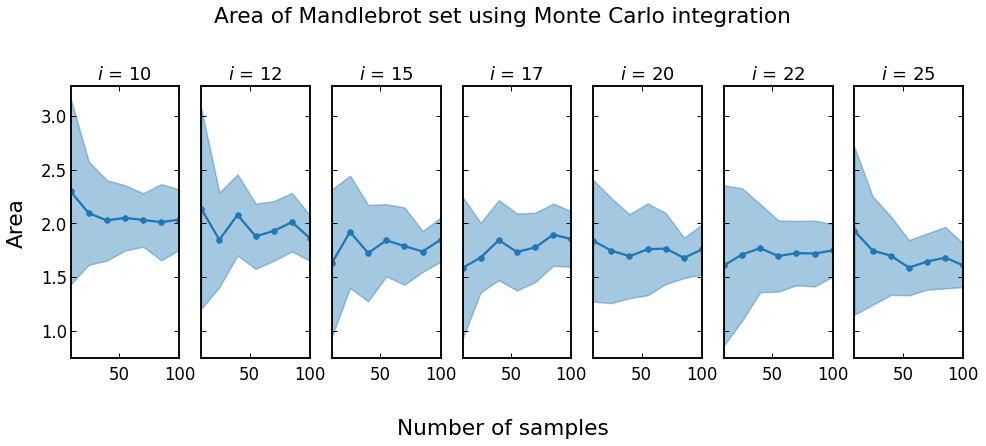

In [ ]:
""" 
Estimates the area for different values of i and s.
"""

n_cores = os.cpu_count()

arr3d = np.zeros((n_different_i, n_different_s))

fig, axs = plt.subplots(1, n_different_i, figsize=(16, 5), sharex=True, sharey=True)
axs = axs.ravel()

for p in tqdm(range(n_different_i)):

    results = np.zeros((n_iterations, n_different_s))

    for m in range(n_different_s):
 
        i = i_range[p]
        s = sample_range[m]
        areas = Parallel(n_jobs=n_cores)(
            delayed(mandlebrot_area)(i, s, uniform_samples) for _ in range(n_iterations)
        )
        results[:, m] = areas

    means = results.mean(axis=0)
    stds = results.std(axis=0)
    arr3d[p] = means
    
    axs[p].plot(sample_range, means, '-o', markersize=5.5)
    axs[p].fill_between(sample_range, means - stds, means + stds, alpha=0.4, edgecolor='tab:blue')
    axs[p].set_title(f'$i$ = {i}')
    axs[p].set_xlim(min_s, max_s)

fig.suptitle('Area of Mandlebrot set using Monte Carlo integration', y=1.1)
fig.supxlabel('Number of samples', y=-0.1)
fig.supylabel('Area', x=0.07)

plt.show()

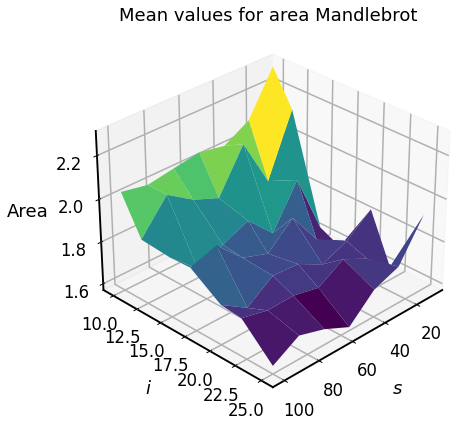

In [ ]:
""" 
3D projection of the area as a function of i and s.
"""

xx, yy = np.meshgrid(sample_range, i_range)

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, arr3d, cmap='viridis')
ax.set(
    xlabel='$s$',
    ylabel='$i$', 
    zlabel='Area',
    title='Mean values for area Mandlebrot'
)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20
ax.view_init(30, 45)
plt.show()